# Imports

In [85]:
import os
import pprint
import tempfile
from typing import Dict, Text

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

import pandas as pd
import sampling

import tensorflow_recommenders as tfrs

import pickle

import matplotlib.pyplot as plt

# Constants

## Load:

In [86]:
RATINGS_BASE = "../Data/base/ratings_base.parquet"
RECIPES_BASE = "../Data/base/recipes_base.parquet"

## Save:

In [4]:
MODEL1_CHECKPOINT = '../Data/TFRS/basic/20_20/ranking/model1/500epochs/model1_ranking_500_epochs_checkpoint'
MODEL1_HISTORY = '../Data/TFRS/basic/20_20/ranking/model1/500epochs/model1_ranking_500_epochs_history.obj'

TOP100_500EPOCHS = '../Data/TFRS/basic/20_20/ranking/model_1/500epochs/top100v500epochs.png'

# Load data

In [87]:
recipes_data = pd.read_parquet(RECIPES_BASE)
ratings_data = pd.read_parquet(RATINGS_BASE)

## Prepare sample

In [88]:
ratings_sample = sampling.get_ratings_with_min_number_list(ratings_data, [20,20])

## Recipes

In [90]:
recipes_sample = recipes[recipes.RecipeId.isin(list(ratings_sample.RecipeId))].copy()

# Prepare dataset

## Ratings

(AuthorId - RecipeId - Rating)

In [91]:
ratings_sample.AuthorId = ratings_sample.AuthorId.map(lambda x: bytes(str(x), 'utf-8'))
ratings_sample.RecipeId = ratings_sample.RecipeId.map(lambda x: bytes(str(x), 'utf-8'))

ratings_dict = ratings_sample.groupby(['AuthorId', 'RecipeId'])['Rating'].sum().reset_index()

ratings_dict = {name: np.array(value) for name, value in ratings_dict.items()}
ratings = tf.data.Dataset.from_tensor_slices(ratings_dict)


ratings = ratings.map(lambda x: {'AuthorId' : x['AuthorId'], 
                                 'RecipeId' : x['RecipeId'],
                                 'Rating' : x['Rating']})

In [92]:
for x in ratings.take(1).as_numpy_iterator():
    pprint.pprint(x)

{'AuthorId': b'100026', 'Rating': 5, 'RecipeId': b'120914'}


## Recipes

For basic version - just ids

In [93]:
recipes_sample.RecipeId = recipes_sample.RecipeId.map(lambda x: bytes(str(x), 'utf-8'))
recipes_dict = recipes_sample[['RecipeId']]
recipes_dict = {name: np.array(value) for name, value in recipes_dict.items()}
recipes = tf.data.Dataset.from_tensor_slices(recipes_dict)

In [94]:
recipes = recipes.map(lambda x: x['RecipeId'])

In [95]:
for x in recipes.take(1).as_numpy_iterator():
    pprint.pprint(x)

b'44'


## Create train, val, test datasets

In [96]:
size = ratings_sample.shape[0]
train_size = int(0.7 * size)
val_size = int(0.15 * size)
test_size = size - train_size - val_size

tf.random.set_seed(42)
shuffled = ratings.shuffle(size, seed=42, reshuffle_each_iteration=False)

train = shuffled.take(train_size)
val = shuffled.take(train_size).take(val_size)
test = shuffled.take(train_size).take(val_size).take(test_size)

print(f"Train size: {train_size}")
print(f"Test size: {test_size}")
print(f"Val size: {val_size}") 

Train size: 217015
Test size: 46504
Val size: 46503


In [97]:
recipe_ids = ratings.batch(1_000_000).map(lambda x: x['RecipeId'])
user_ids = ratings.batch(1_000_000).map(lambda x: x["AuthorId"])

unique_recipe_ids = np.unique(np.concatenate(list(recipe_ids)))
unique_user_ids = np.unique(np.concatenate(list(user_ids)))

# Model

## Train

In [111]:
model_1 = RecipeRankingModel()
model_1.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1))

In [112]:
cached_train = train.shuffle(250_000).batch(16384).cache()
cached_test = test.batch(4096).cache()
cached_val = val.batch(4096).cache()

## Fit

In [1]:
%%time
model_1_history = model_1.fit(cached_train,
                              epochs=500, 
                              verbose=0,
                              validation_data=cached_val,
                              validation_freq=5)

## Save

In [105]:
# model_1.save_weights(MODEL1_CHECKPOINT)
# with open(MODEL1_HISTORY, 'wb') as pickle_file:
#     pickle.dump(model_1_history.history, pickle_file)

In [106]:
model_1_history.history.keys()

dict_keys(['root_mean_squared_error', 'loss', 'regularization_loss', 'total_loss', 'val_root_mean_squared_error', 'val_loss', 'val_regularization_loss', 'val_total_loss'])

## Plot

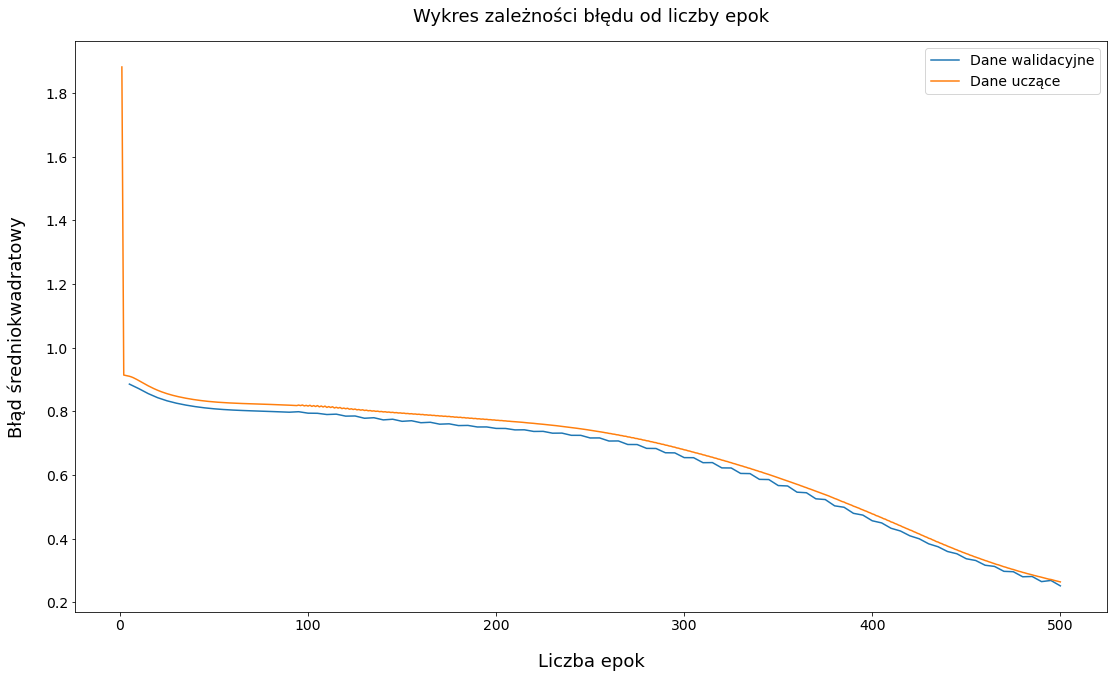

In [107]:
history_val = model_1_history.history["val_root_mean_squared_error"]
history_train = model_1_history.history["root_mean_squared_error"]

num_validation_runs = len(history_val)
epochs_val = [(x + 1)* 5 for x in range(num_validation_runs)]

num_validation_runs = len(history_train)
epochs_train = [(x + 1)* 1 for x in range(num_validation_runs)]

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.rcParams['axes.titlepad'] = 20

plt.plot(epochs_val, history_val, label='Dane walidacyjne')
plt.plot(epochs_train, history_train, label='Dane uczące')

plt.xlabel("Liczba epok", fontsize=18, labelpad=20)
plt.ylabel("Błąd średniokwadratowy", fontsize=18, labelpad=20)
# plt.scatter(x[0], y[0])
# plt.scatter(x[4], y[4])
# plt.scatter(x[-1], y[-1])

# plt.text(x[0]+1, y[0], f"({x[0]}, {round(y[0],2)})", fontsize=16)
# plt.text(x[4]+1, y[4]+0.01, f"({x[4]}, {round(y[4],2)})", fontsize=16)
# plt.text(x[-1]-7, y[-1]+0.015, f"({x[-1]}, {round(y[-1],2)})", fontsize=16)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title("Wykres zależności błędu od liczby epok", fontsize=18)
plt.legend(fontsize=14)
plt.show()

# fig.savefig(TOP100_500EPOCHS, dpi=100)

In [108]:
model_1.evaluate(cached_test, return_dict=True)

12/12 [==============================] - 1s 62ms/step - root_mean_squared_error: 0.2516 - loss: 0.0632 - regularization_loss: 0.0000e+00 - total_loss: 0.0632


{'root_mean_squared_error': 0.2516079545021057,
 'loss': 0.06214195489883423,
 'regularization_loss': 0,
 'total_loss': 0.06214195489883423}